## IQL

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
from IPython.display import clear_output
from pettingzoo import ParallelEnv
from gymnasium import spaces
# FIX: Import np_random utility for correct seeding/random number generation
from gymnasium.utils.seeding import np_random 

## Multi-Agent Independent Q-Learning (IQL) for the Extended Taxi Problem

#### This notebook implements Independent Q-Learning (IQL), the first Multi-Agent Reinforcement Learning (MARL) baseline for the competitive, two-taxi environment, based on the *PettingZoo* API.
##### *Goal:* Two agents (⁠ taxi_0 ⁠, ⁠ taxi_1 ⁠) compete to pick up a single passenger and drop them off at the destination first.

### 1. Setup and Environment Definition

In [32]:
# --- UTILITY FUNCTIONS ---
# These functions are necessary for the visualization components later in the notebook.
def run_animation(experience_buffer):
    """Function to run animation (simplified for text-only output)"""
    time_lag = 0.05  # Delay (in s) between frames
    
    print("\n--- Running Evaluation Animation ---")
    for experience in experience_buffer:
        # Print console output
        print(f"Episode: {experience['episode']} | Step: {experience['step']} | Agent: {experience['agent']} | Reward: {experience['reward']}")
        print(experience['frame'])
        time.sleep(time_lag)

def get_mean_rewards(rewards_list, window=1000):
    """Calculates the rolling average of rewards for plotting."""
    if not rewards_list:
        return np.array([])
    return np.convolve(rewards_list, np.ones(window)/window, mode='valid')

### 2. Custom Multi-Agent Taxi Environment (⁠ MultiTaxiEnv ⁠)
##### This class extends the PettingZoo ⁠ ParallelEnv ⁠ to handle the competitive 2-taxi dynamics.

In [33]:
class MultiTaxiEnv(ParallelEnv):
    metadata = {"render_modes": ["ansi", "human"], "name": "multi_taxi_v1"}

    def __init__(self, render_mode="ansi", cooperative=False): # Added cooperative flag
        # FIX 1: Initialize np_random here for use in reset and randomization.
        self.np_random, _ = np_random() 
        self.cooperative = cooperative # Store cooperation mode

        self.render_mode = render_mode
        
        # Grid definition (Same as Taxi-v3)
        self.desc = np.asarray([
            "+---------+",
            "|R: | : :G|",
            "| : | : : |",
            "| : : : : |",
            "| | : | : |",
            "|Y| : |B: |",
            "+---------+",
        ], dtype="c")

        # Destination coordinates (R, G, Y, B)
        self.locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        # Agents
        self.possible_agents = ["taxi_0", "taxi_1"]
        self.agents = self.possible_agents[:]

        # Action Space: Discrete (6) - 0:south, 1:north, 2:east, 3:west, 4:pickup, 5:dropoff
        self.action_spaces = {agent: spaces.Discrete(6) for agent in self.agents}

        # Observation Space (Local State for IQL):
        # (MyRow, MyCol, OppRow, OppCol, PassLoc/Status (0-5), Dest (0-3))
        # 5 * 5 * 5 * 5 * 6 * 4 = 15,000 states
        self.observation_spaces = {
            agent: spaces.Discrete(15000) for agent in self.agents
        }
        
    def action_space(self, agent): return self.action_spaces[agent]
    def observation_space(self, agent): return self.observation_spaces[agent]

    def reset(self, seed=None, options=None):
        # FIX 2: If a seed is passed, re-initialize np_random to ensure reproducibility.
        if seed is not None:
             self.np_random, _ = np_random(seed)
             
        self.agents = self.possible_agents[:]
        self.timestep = 0
        
        # 1. Randomize Taxi Locations
        self.taxi_locs = {
            # FIX 3: Change .randint to .integers for modern NumPy Generator object
            "taxi_0": [self.np_random.integers(5), self.np_random.integers(5)],
            "taxi_1": [self.np_random.integers(5), self.np_random.integers(5)]
        }
        
        # 2. Random Passenger and Destination
        # FIX 4: Change .randint to .integers
        self.pass_idx = self.np_random.integers(4) # 0-3 (R, G, Y, B)
        self.pass_loc = list(self.locs[self.pass_idx])
        
        # FIX 5: Change .randint to .integers
        self.dest_idx = self.np_random.integers(4)
        while self.dest_idx == self.pass_idx:
            # FIX 6: Change .randint to .integers
            self.dest_idx = self.np_random.integers(4)
        
        # 3. Status: 0=Waiting, 1=In Taxi 0, 2=In Taxi 1, 3=Delivered
        self.pass_status = 0 
        
        observations = {
            a: self._encode_obs(a) for a in self.agents
        }
        infos = {a: {} for a in self.agents}
        
        return observations, infos

    def step(self, actions):
        rewards = {a: -0.5 for a in self.agents} # Default step cost
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}
        infos = {a: {} for a in self.agents}
        
        # Process agents in random order to break simultaneous tie in movement
        agents_order = self.agents[:]
        self.np_random.shuffle(agents_order)

        for agent in agents_order:
            action = actions.get(agent)
            if action is None: continue 
            
            row, col = self.taxi_locs[agent]
            
            # --- MOVEMENT (0-3) ---
            if action < 4:
                new_row, new_col = row, col
                # Movement logic (south, north, east, west) with wall checks
                if action == 0: new_row = min(row + 1, 4)
                elif action == 1: new_row = max(row - 1, 0)
                elif action == 2: # East
                    if self.desc[1 + row, 2 * col + 2] == b":": new_col = min(col + 1, 4)
                elif action == 3: # West
                    if self.desc[1 + row, 2 * col] == b":": new_col = max(col - 1, 0)
                
                self.taxi_locs[agent] = [new_row, new_col]

            # --- PICKUP (4) ---
            elif action == 4:
                at_passenger = (self.taxi_locs[agent] == self.pass_loc)
            
                # Case 1: Passenger waiting AND taxi is at passenger location
                if self.pass_status == 0 and at_passenger:
                    # Successful pickup
                    self.pass_status = (1 if agent == "taxi_0" else 2)
            
                    if self.cooperative:
                        # Shared reward
                        for a in self.agents:
                            rewards[a] += 25
                    else:
                        # Competitive pickup reward
                        rewards[agent] += 25
                        for a in self.agents:
                            if a != agent:
                                rewards[a] += -5
                # Case 2: Passenger waiting but taxi not at correct location
                elif self.pass_status == 0:
                    rewards[agent] += -5
                # Case 3: Passenger already picked up
                else:
                    if self.cooperative:
                        rewards[agent] += -5
                    else:
                        pass  # No penalty in competitive mode
                        
            # --- DROPOFF (5) ---
            elif action == 5:
            
                carrying = (
                    (self.pass_status == 1 and agent == "taxi_0") or
                    (self.pass_status == 2 and agent == "taxi_1")
                )
                if carrying:
                    dest_loc = list(self.locs[self.dest_idx])
            
                    if self.taxi_locs[agent] == dest_loc:
                        # Successful dropoff
                        if self.cooperative:
                            for a in self.agents:
                                rewards[a] += 50
                        else:
                            rewards[agent] += 50
                            for a in self.agents:
                                if a != agent:
                                    rewards[a] += -10
            
                        self.pass_status = 3
                        terminations = {a: True for a in self.agents}
                    else:
                        # Wrong destination
                        rewards[agent] += -5
                else:
                    # Not carrying passenger
                    rewards[agent] += -5


        # Update Observations after all moves
        observations = {a: self._encode_obs(a) for a in self.agents}
        
        # Check truncation (timeout)
        self.timestep += 1
        if self.timestep >= 150: # Using MAX_STEPS_PER_EPISODE from training
            truncations = {a: True for a in self.agents}
            
        return observations, rewards, terminations, truncations, infos

    def _encode_obs(self, agent_id):
        # Encode state into a single integer for Q-table
        # (MyRow, MyCol, OppRow, OppCol, PassLoc/Status, Dest)
        my_row, my_col = self.taxi_locs[agent_id]
        
        opp_id = self.possible_agents[1] if agent_id == self.possible_agents[0] else self.possible_agents[0]
        opp_row, opp_col = self.taxi_locs[opp_id]
        
        # Passenger encoding: 0-3 (locs), 4 (in taxi 0), 5 (in taxi 1)
        pass_idx = self.pass_status if self.pass_status in [1, 2] else self.pass_idx
        # Note: When status=0 (waiting) or status=3 (delivered), pass_idx is the original location index.
        # When status=1 (T0 carrying), pass_idx=4. When status=2 (T1 carrying), pass_idx=5.
        
        dest_idx = self.dest_idx
        
        # State calculation logic (5 * 5 * 5 * 5 * 6 * 4 = 15,000)
        i = my_row
        i *= 5; i += my_col
        i *= 5; i += opp_row
        i *= 5; i += opp_col
        i *= 6; i += pass_idx 
        i *= 4; i += dest_idx
        return i

    def render(self):
        # Simple ASCII Render for 'ansi' mode
        if self.render_mode != "ansi":
             # In a real environment, you'd render to a window here
             return "Render mode not supported outside notebook." 
             
        out = self.desc.copy().tolist()
        out = [[c.decode("utf-8") for c in line] for line in out]

        # Helper for coloring (simplified for standard terminal)
        def set_char(r, c, char):
            out[1 + r][2 * c + 1] = char

        # 1. Color Destination (B)
        di, dj = self.locs[self.dest_idx]
        set_char(di, dj, out[1 + di][2 * dj + 1].upper()) 
        
        # 2. Color Passenger (R)
        if self.pass_status == 0:
            pi, pj = self.pass_loc
            set_char(pi, pj, out[1 + pi][2 * pj + 1].lower())

        # 3. Place Taxis (0 and 1)
        t0_r, t0_c = self.taxi_locs["taxi_0"]
        t1_r, t1_c = self.taxi_locs["taxi_1"]
        
        # Prioritize Taxi carrying passenger
        if self.pass_status == 1:
            set_char(t0_r, t0_c, "T")
            set_char(t1_r, t1_c, "1")
        elif self.pass_status == 2:
            set_char(t0_r, t0_c, "0")
            set_char(t1_r, t1_c, "T")
        else:
            set_char(t0_r, t0_c, "0")
            set_char(t1_r, t1_c, "1")

        return "\n".join(["".join(row) for row in out])


### 3. IQL Training Setup and Loop

In [37]:
# --- MARL Hyperparameters ---
LEARNING_RATE = 0.1     # (alpha)
DISCOUNT_FACTOR = 0.99  # (gamma)
EPISODES = 100000       # *FIX: Increased Training episodes from 20k to 100k*
MAX_STEPS_PER_EPISODE = 150 

# Epsilon-Greedy Strategy Parameters 
EPSILON_START = 1.0     
EPSILON_END = 0.05      
EPSILON_DECAY_RATE = 0.00002 # *FIX: Decreased decay rate to match 100k episodes*

# Initialize Environment
# --- IMPORTANT CHANGE: SWITCH TO COOPERATIVE/COMPETITIVE MODE ---
env_marl = MultiTaxiEnv(render_mode="ansi", cooperative=True) 
agents = env_marl.possible_agents

# Get state and action sizes for Q-tables
state_size = env_marl.observation_spaces[agents[0]].n
action_size = env_marl.action_spaces[agents[0]].n

# Initialize two separate Q-tables for IQL
q_table = {
    agents[0]: np.zeros((state_size, action_size)),
    agents[1]: np.zeros((state_size, action_size))
}

print(f"IQL State Size: {state_size} (15,000) | Action Size: {action_size} (6)")
print(f"Q-tables initialized for {agents[0]} and {agents[1]}")
print(f"--- Running in Cooperative Mode: {env_marl.cooperative} ---")

def choose_action(agent_id, state, q_table, epsilon):
    """Epsilon-greedy strategy for a single agent."""
    if np.random.random() < epsilon:
        # Explore: Choose a random action
        return env_marl.action_spaces[agent_id].sample()
    else:
        # Exploit: Choose the action with the max Q-value
        return np.argmax(q_table[agent_id][state, :])

epsilon = EPSILON_START
training_rewards_0 = []
training_rewards_1 = []

if(env_marl.cooperative):
    mode = "Cooperative"
else:
    mode = "Competitive"
    
print(f"\n=== Starting IQL Training ({mode}) ===")

for episode in range(1, EPISODES + 1):
    observations, _ = env_marl.reset()
    terminated = {a: False for a in agents}
    truncated = {a: False for a in agents}
    episode_rewards = {a: 0 for a in agents}

    for step in range(MAX_STEPS_PER_EPISODE):
        
        # 1. Choose actions for both agents
        actions = {
            a: choose_action(a, observations[a], q_table, epsilon) for a in agents
        }
        
        # 2. Step the environment
        new_observations, rewards, terminated, truncated, _ = env_marl.step(actions)
        
        # 3. IQL Update for EACH Agent (Independent Update)
        for agent_id in agents:
            state = observations[agent_id]
            action = actions[agent_id]
            reward = rewards[agent_id]
            new_state = new_observations[agent_id]
            
            # Q-Learning Update
            old_q_value = q_table[agent_id][state, action]
            max_future_q = np.max(q_table[agent_id][new_state, :])
            
            new_q_value = (1 - LEARNING_RATE) * old_q_value + LEARNING_RATE * (reward + DISCOUNT_FACTOR * max_future_q)
            q_table[agent_id][state, action] = new_q_value
            
            episode_rewards[agent_id] += reward
        
        observations = new_observations
        
        if any(terminated.values()) or any(truncated.values()):
            break
    
    # Decay Epsilon
    epsilon = max(EPSILON_END, epsilon - EPSILON_DECAY_RATE)
    
    # Log Rewards
    training_rewards_0.append(episode_rewards[agents[0]])
    training_rewards_1.append(episode_rewards[agents[1]])
    
    if episode % 5000 == 0: # Adjusted logging frequency for 100k episodes
        avg_r0 = np.mean(training_rewards_0[-5000:])
        avg_r1 = np.mean(training_rewards_1[-5000:])
        print(f"Episode: {episode} | Avg R0: {avg_r0:.2f} | Avg R1: {avg_r1:.2f} | Epsilon: {epsilon:.4f}")

print("\n=== IQL Training Completed. ===")

IQL State Size: 15000 (15,000) | Action Size: 6 (6)
Q-tables initialized for taxi_0 and taxi_1
--- Running in Cooperative Mode: True ---

=== Starting IQL Training (Cooperative) ===
Episode: 5000 | Avg R0: -266.95 | Avg R1: -267.35 | Epsilon: 0.9000
Episode: 10000 | Avg R0: -159.70 | Avg R1: -160.29 | Epsilon: 0.8000
Episode: 15000 | Avg R0: -63.51 | Avg R1: -63.71 | Epsilon: 0.7000
Episode: 20000 | Avg R0: -11.83 | Avg R1: -12.04 | Epsilon: 0.6000
Episode: 25000 | Avg R0: 16.68 | Avg R1: 17.38 | Epsilon: 0.5000
Episode: 30000 | Avg R0: 28.63 | Avg R1: 28.29 | Epsilon: 0.4000
Episode: 35000 | Avg R0: 35.04 | Avg R1: 35.86 | Epsilon: 0.3000
Episode: 40000 | Avg R0: 37.05 | Avg R1: 37.51 | Epsilon: 0.2000
Episode: 45000 | Avg R0: 40.76 | Avg R1: 41.33 | Epsilon: 0.1000
Episode: 50000 | Avg R0: 30.26 | Avg R1: 31.83 | Epsilon: 0.0500
Episode: 55000 | Avg R0: 53.64 | Avg R1: 53.82 | Epsilon: 0.0500
Episode: 60000 | Avg R0: 48.29 | Avg R1: 49.00 | Epsilon: 0.0500
Episode: 65000 | Avg R0: 37

### 4. Plotting Convergence
#### Cooperative Analysis: In the cooperative setting, we expect both reward curves to track much closer together and converge to a higher reward than the competitive baseline, indicating better overall system efficiency.

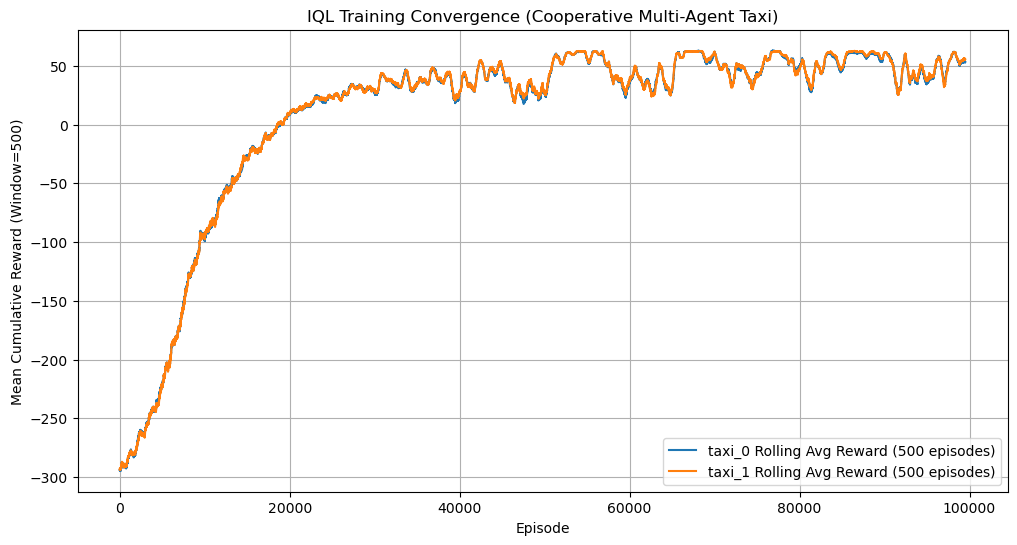


--- Starting IQL Evaluation (Cooperative) ---
Episode 1 finished in 14 steps. Mission Success: Both
Episode 2 finished in 15 steps. Mission Success: Both
Episode 4 finished in 10 steps. Mission Success: Both
Episode 5 finished in 13 steps. Mission Success: Both
Episode 6 finished in 18 steps. Mission Success: Both
Episode 7 finished in 26 steps. Mission Success: Both
Episode 9 finished in 17 steps. Mission Success: Both
Episode 10 finished in 12 steps. Mission Success: Both
Episode 12 finished in 28 steps. Mission Success: Both
Episode 13 finished in 20 steps. Mission Success: Both
Episode 14 finished in 10 steps. Mission Success: Both
Episode 15 finished in 11 steps. Mission Success: Both
Episode 17 finished in 9 steps. Mission Success: Both
Episode 18 finished in 19 steps. Mission Success: Both
Episode 19 finished in 22 steps. Mission Success: Both
Episode 20 finished in 24 steps. Mission Success: Both
Episode 21 finished in 20 steps. Mission Success: Both
Episode 22 finished in 15 

In [38]:
# Use a rolling average for smoother visualization
ROLLING_WINDOW = 500
mean_rewards_0 = get_mean_rewards(training_rewards_0, ROLLING_WINDOW)
mean_rewards_1 = get_mean_rewards(training_rewards_1, ROLLING_WINDOW)

plt.figure(figsize=(12, 6))
plt.plot(mean_rewards_0, label=f'{agents[0]} Rolling Avg Reward ({ROLLING_WINDOW} episodes)')
plt.plot(mean_rewards_1, label=f'{agents[1]} Rolling Avg Reward ({ROLLING_WINDOW} episodes)')
plt.title('IQL Training Convergence ({} Multi-Agent Taxi)'.format(mode))
plt.xlabel('Episode')
plt.ylabel(f'Mean Cumulative Reward (Window={ROLLING_WINDOW})')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
# ## 5. Performance Test and Evaluation
# 
# We evaluate the learned policy using pure exploitation (no random actions).
# 
# # %%
"""Test policy performance after training"""

EVAL_EPISODES = 100
experience_buffer = []

# Metrics
total_wins = {a: 0 for a in agents}
total_steps = 0
total_reward = {a: 0 for a in agents}
invalid_pickups = {a: 0 for a in agents}

print(f"\n--- Starting IQL Evaluation ({mode}) ---")

for episode in range(EVAL_EPISODES):
    observations, _ = env_marl.reset()
    terminated = {a: False for a in agents}
    truncated = {a: False for a in agents}
    current_step = 0

    while not any(terminated.values()) and not any(truncated.values()):
        current_step += 1
        
        # Exploit only: Choose the best action based on the Q-table
        actions = {
            a: np.argmax(q_table[a][observations[a], :]) for a in agents
        }

        prev_status = env_marl.pass_status  # 0: waiting, 1: in taxi_0, 2: in taxi_1, 3: delivered
        for a in agents:
            if actions[a] == 4 and prev_status in (1, 2):
                invalid_pickups[a] += 1
        
        new_observations, rewards, terminated, truncated, _ = env_marl.step(actions)
        
        # Log performance
        for a in agents:
            total_reward[a] += rewards[a]
            experience_buffer.append({
                'frame': env_marl.render(),
                'episode': episode + 1,
                'step': current_step,
                'agent': a,
                'reward': total_reward[a]
            })

        observations = new_observations
        
        if any(terminated.values()):
            winner = None
            # In cooperative mode, both agents get positive reward
            if rewards[agents[0]] > 0 and rewards[agents[1]] > 0:
                total_wins[agents[0]] += 1
                total_wins[agents[1]] += 1
                winner = "Both"
            print(f"Episode {episode + 1} finished in {current_step} steps. Mission Success: {winner}")
            
    total_steps += current_step
    
# Display evaluation summary
run_animation(experience_buffer[:50]) # Displaying only the first 50 steps for brevity

print(f"\n--- FINAL EVALUATION RESULTS ({mode}) ---")
print(f"Total Episodes Tested: {EVAL_EPISODES}")
print(f"Mean Steps per Episode: {total_steps / EVAL_EPISODES:.2f}")
print(f"Mission Success Rate: {total_wins[agents[0]] / EVAL_EPISODES * 100:.1f}%")
print(f"Average Reward {agents[0]}: {total_reward[agents[0]] / EVAL_EPISODES:.2f}")
print(f"Average Reward {agents[1]}: {total_reward[agents[1]] / EVAL_EPISODES:.2f}")

### 6. Saving Q-Tables
##### Save the trained Q-tables for reproducibility, just like you did for the single-agent baseline.

In [39]:
if env_marl.cooperative:
    np.save("marl_taxi_q_table_0_coop.npy", q_table[agents[0]])
    np.save("marl_taxi_q_table_1_coop.npy", q_table[agents[1]])
    print("Saved Cooperative Q-tables for taxi_0 and taxi_1.")
else:
    np.save("marl_taxi_q_table_0_comp.npy", q_table[agents[0]])
    np.save("marl_taxi_q_table_1_comp.npy", q_table[agents[1]])
    print("Saved Comperative Q-tables for taxi_0 and taxi_1.")

Saved Cooperative Q-tables for taxi_0 and taxi_1.
